En este notebook se carga el modelo de regresión ganador (regresión lineal) y se infiere sobre un registro del conjunto de test, para visualizar el ajuste de resultados (predicciones) frente a valores reales.

### Carga de dataset
formado por activaciones de 600 escenarios (y selección del 60% de neuronas relevantes)

In [1]:
import torch
dataset = torch.load('./workspace/dataset_to_train_regressor_60_percent_neurons.pt', weights_only=False)
print(f"Dataset cargado. Número de tokens: {len(dataset)}")

Dataset cargado. Número de tokens: 110582


### División del conjunto de datos con la misma configuración que se utiliza para entrenar el modelo

In [3]:
from torch.utils.data import random_split
import numpy as np

torch.manual_seed(0)

total_len = len(dataset)
train_len = int(0.6 * total_len)
val_len   = int(0.2 * total_len)
test_len  = total_len - train_len - val_len

train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

X_train, Y_train, z_train = [x.cpu().numpy() for x, y, z in train_set], [y.cpu().numpy() for x, y, z in train_set], [z.cpu().numpy() for x, y, z in train_set]
X_val,   Y_val,   z_val   = [x.cpu().numpy() for x, y, z in val_set],   [y.cpu().numpy() for x, y, z in val_set],   [z.cpu().numpy() for x, y, z in val_set]
X_test,  Y_test,  z_test  = [x.cpu().numpy() for x, y, z in test_set],  [y.cpu().numpy() for x, y, z in test_set],  [z.cpu().numpy() for x, y, z in test_set]

X_train, Y_train, z_train = np.stack(X_train), np.stack(Y_train), np.stack(z_train)
X_val,   Y_val,   z_val   = np.stack(X_val),   np.stack(Y_val),   np.stack(z_val)
X_test,  Y_test,  z_test  = np.stack(X_test),  np.stack(Y_test),  np.stack(z_test)


### Carga del modelo de regresión lineal

In [ ]:
# Importar el modelo guardado
import joblib
import numpy as np

linear_model = joblib.load("./workspace/models/linear_model.pkl")

### Inferencia sobre un registro de conjunto de test

In [7]:
# Elegir un registro de test (por ejemplo el primero)
x_test, y_true, z_test = test_set[20]
x_test_np = x_test.unsqueeze(0).cpu().numpy()  # [1, n_neuronas]

# Predicción
y_pred = linear_model.predict(x_test_np)

# print("Activaciones faker (entrada):", x_test_np)
# print("Activaciones alineadas (verdad):", y_true.cpu().numpy())
# print("Predicción del modelo Linear:", y_pred)

### Visualización predicciones vs. vector alineado real

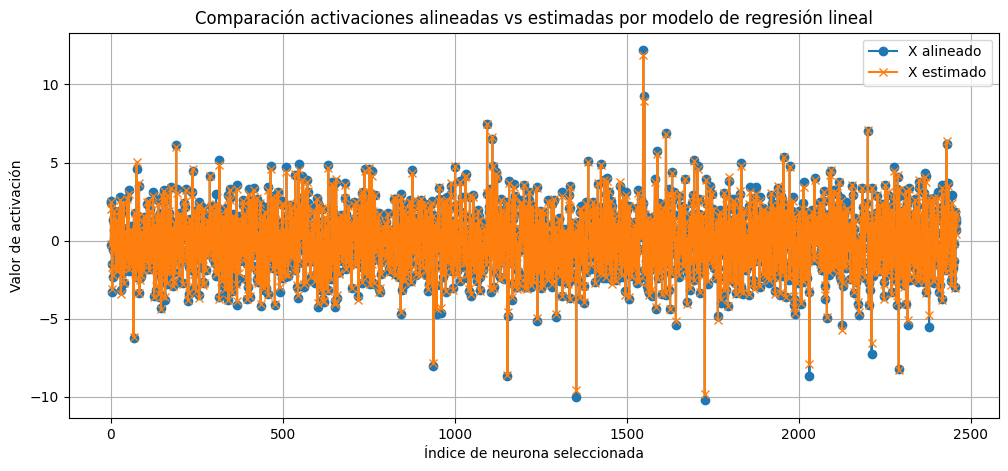

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_true.cpu().numpy(), label="X alineado", marker='o')
plt.plot(y_pred.ravel(), label="X estimado", marker='x')
plt.xlabel("Índice de neurona seleccionada")
plt.ylabel("Valor de activación")
plt.title("Comparación activaciones alineadas vs estimadas por modelo de regresión lineal")
plt.legend()
plt.grid(True)
plt.show()

### Inferencia sobre varios registros

In [10]:
# Extraer múltiples registros
x_test_batch = []
y_true_batch = []

for i in range(len(test_set)):  # por ejemplo, los primeros 10 registros
    x, y, z = test_set[i]
    x_test_batch.append(x.cpu().numpy())
    y_true_batch.append(y.cpu().numpy())

# Convertir a numpy array 2D
x_test_batch_np = np.stack(x_test_batch)  # forma [10, n_neuronas]
y_true_batch_np = np.stack(y_true_batch)

# Predicción sobre todo el batch
y_pred_batch = linear_model.predict(x_test_batch_np)

# print("Activaciones faker (entrada):", x_test_batch_np)
# print("Activaciones alineadas (verdad):", y_true_batch_np)
# print("Predicciones del modelo Linear:", y_pred_batch)


In [11]:
import numpy as np
from sklearn.metrics import r2_score

def compute_metrics(Y_true, Y_pred):
    # RMSE "global" (aplanado) → lo que ya usabas
    rmse = np.sqrt(((Y_true - Y_pred) ** 2).mean())
    r2 = r2_score(Y_true, Y_pred, multioutput='variance_weighted')
    
    return {
        "RMSE": rmse,
        "R2": r2,
    }

compute_metrics(y_true_batch_np, y_pred_batch)

{'RMSE': np.float32(0.6721627), 'R2': 0.8326299786567688}